# 의문점 : 넷플릭스는 왜 이렇게 옛날 거 밖에 없을까? 요즘 애들은 그런 걸 좋아하나?

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# netflix data 불러오기

In [4]:
PATH = os.getenv("HOME") + "/publish/data/"
csv_path = PATH + 'netflix_titles.csv'
data = pd.read_csv(csv_path)
data_copy=data.copy()
df = pd.DataFrame(data)
df['date_added'] = pd.to_datetime(df['date_added'])
csv_path = PATH + "netflix_stockprice.csv"
data2 = pd.read_csv(csv_path)
data2_copy=data2.copy()
df2 = pd.DataFrame(data2)
df2['Date'] = pd.to_datetime(df2['Date'])
df_titles_stockprice = pd.merge(df, df2, left_on='date_added', right_on='Date', how='inner')
csv_path = PATH + "rate_only.csv"
data3 = pd.read_csv(csv_path)
data3_copy=data3.copy()
df3 = pd.DataFrame(data3)
df3['date_added'] = pd.to_datetime(df3['date_added'])
# 원본 + 주가 데이터에 평점 데이터까지 합치기
df_titles_rating_stockprice = pd.merge(df3, df2, left_on='date_added', right_on='Date', how='inner')
csv_path = PATH + "SPX_500_Data.csv"
data4 = pd.read_csv(csv_path)
data4_copy=data4.copy()
df4 = pd.DataFrame(data4)

# df4 형식 datetime64로 맞춰주기
df4['Date'] = pd.to_datetime(df4['Date'])

# 원본 + 주가 + 평점 데이터에 S&P500 데이터까지 합치기 -> 겹치는 column명은 _x, _y로 라벨링됨
df_titles_rating_stockprice_SP500 = pd.merge(df_titles_rating_stockprice, df4, left_on='date_added', right_on='Date', how='inner')

# 날짜 숫자로 바꿔주기
df['date_added'] = pd.to_datetime(df['date_added'])

## Netflix EDA

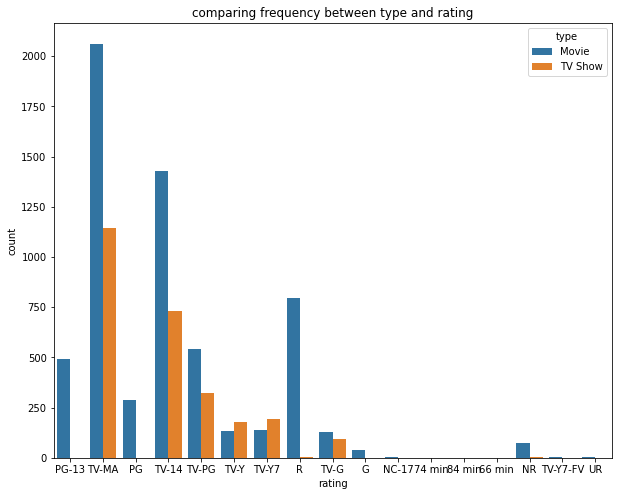

In [5]:
plt.figure(figsize=(10,8))
sns.countplot(x='rating',hue='type',data=df)
plt.title('comparing frequency between type and rating')
plt.show()

### 나라별 영화, 드라마 비율

In [6]:
df['country'].value_counts().sort_values(ascending = False)

United States                                           2818
India                                                    972
United Kingdom                                           419
Japan                                                    245
South Korea                                              199
                                                        ... 
Ireland, United Kingdom, Greece, France, Netherlands       1
France, Canada, Italy, United States, China                1
United States, Venezuela                                   1
United Kingdom, Canada, Japan                              1
United Arab Emirates, Jordan                               1
Name: country, Length: 748, dtype: int64

In [7]:
top_productive_countries = df[(df['country']=='United States') |
                                  (df['country']=='India')|
                                  (df['country']=='United Kingdom')|
                                  (df['country']=='Japan')|
                                  (df['country']=='South Korea')]

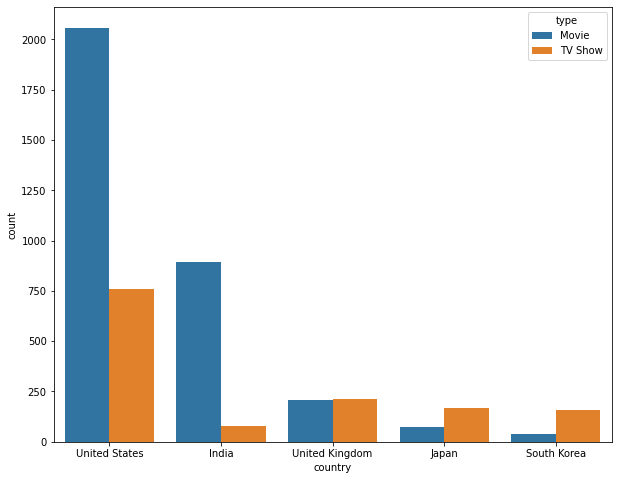

In [8]:
plt.figure(figsize = (10,8))
sns.countplot(x = 'country', hue = 'type', data = top_productive_countries)
plt.show()

<AxesSubplot:ylabel='rating'>

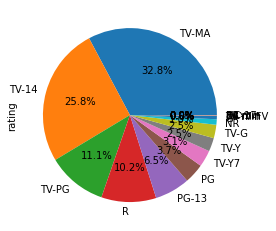

In [9]:
(top_productive_countries['rating'].value_counts(normalize=True)*100).plot(kind='pie',autopct='%.1f%%')

In [10]:
country_subscriber = pd.read_csv(PATH + "num_of_subscribers.csv")

In [11]:
#나라별 넷플릭스 구독자
top_five_viewers = country_subscriber.sort_values(by = ['# of Netflix Subscribers'], axis=0, ascending=False )[:5]

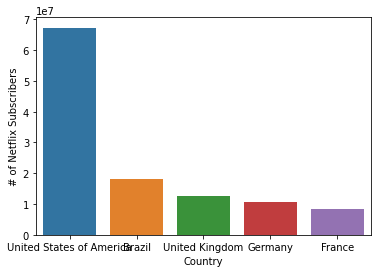

In [12]:
sns.barplot(
    data= top_five_viewers,
    x= "Country",
    y= "# of Netflix Subscribers"
)

plt.show()

In [13]:
#인구 대비 넷플릭스 구독자 비율
top_five_percentile = country_subscriber.sort_values(by = ['% of Population with a Netflix Subscription'], axis=0, ascending=False)[:5]

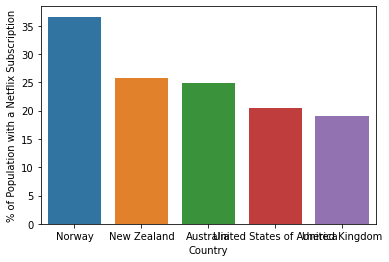

In [14]:
sns.barplot(
    data= top_five_percentile,
    x= "Country",
    y= "% of Population with a Netflix Subscription"
)

plt.show()

In [15]:
#시간별로 vote 수
popular=pd.read_csv(PATH + "popular_des2.csv",index_col=0)
no_popular = pd.read_csv(PATH + "non_popular_des2.csv",index_col=0)

In [16]:
popular[:5]

description_x
1   On a photo shoot in Ghana, an American model s...
7   A rookie cop with one day to prove himself to ...
8   When a powerful businesswoman’s political ambi...
11  Bored with being the Lord of Hell, the devil r...
19  After growing up amidst the gang wars of his h...

# LDA

* 잠재 디레클레 할당(LDA)은 대표적인 토픽 모델링  알고리즘 중 하나

* 잠재 디레클레 할당 방법
  1. 사용자가 토픽이 개수를 지정해 알고리즘에 전달
  2. 모든 단어들을 토픽 중 하나에 할당
  3. 모든 문서의 모든 단어에 대해 단어 w가 가정에 의거, $p(t|d)$, $p(w|t)$에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미    

* $p(t|d)$ - 문서 d의 단어들 중 토픽 t에 해당하는 비율
* 해당 문서의 자주 등장하는 다른 단어의 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미    

* $p(w|t)$- 단어 w를 가지고 있는 모든 문서들 중  토픽 t가 할당된 비율
* 다른 문서에서 단어 w에 많이 할당된 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미

시각화

- 주성분 pc1,2로 2차원 형태로 표현 합니다.

- 좌측의 원들은 각각의 20개의 토픽을 나타냅니다. 각 원과의 거리는 각 토픽들이 서로 얼마나 다른지를 보여줌 만약 두 개의 원이 겹친다면, 이 두 개의 토픽은 유사한 토픽이라는 의미입니다.

- 우측에는 각 등장하는 그 단어들이 해당 토픽에서 얼만큼 등장하는지 term frequency 를 나타냅니다.

In [17]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [18]:
popular_list = popular.values.tolist()
no_popular_list = no_popular.values.tolist()
popular_list[:5]

[['On a photo shoot in Ghana, an American model slips back in time, becomes enslaved on a plantation and bears witness to the agony of her ancestral past.'],
 ["A rookie cop with one day to prove himself to a veteran LAPD narcotics officer receives a crash course in his mentor's questionable brand of justice."],
 ['When a powerful businesswoman’s political ambitions are threatened by her underworld connections, the ensuing power struggle could cost her everything.'],
 ['Bored with being the Lord of Hell, the devil relocates to Los Angeles, where he opens a nightclub and forms a connection with a homicide detective.'],
 ['After growing up amidst the gang wars of his hometown, Vincent forms an entrepreneurial squad of his own and ends up on the wrong side of the law.']]

In [19]:
import itertools
popular_list =list(itertools.chain.from_iterable(popular_list))
no_popular_list=list(itertools.chain.from_iterable(no_popular_list))

In [20]:
#텍스트 전처리
news_df = pd.DataFrame({'document':no_popular_list})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/var/folders/z_/fl1l3lj16n55t2wwqw4xkcw80000gn/T/ipykernel_46449/1490011020.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [21]:
news_df['clean_doc'][1]

'blackmailed company level employee finds himself forced boss rival former mentor'

In [22]:
import nltk
nltk.download('stopwords')
  
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # NLTK로부터 불용어를 받아옵니다.
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
# 불용어를 제거합니다.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taekkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
print(tokenized_doc[1])

['blackmailed', 'company', 'level', 'employee', 'finds', 'forced', 'boss', 'rival', 'former', 'mentor']


In [24]:
#3) TF-IDF 행렬 만들기
# 역토큰화 (토큰화 작업을 역으로 되돌림)
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [25]:
news_df['clean_doc'][1]

'blackmailed company level employee finds forced boss rival former mentor'

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # 상위 1,000개의 단어를 보존 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])
X.shape # TF-IDF 행렬의 크기 확인

(770, 1000)

In [27]:
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)
len(svd_model.components_)

20

In [28]:
np.shape(svd_model.components_)


(20, 1000)

In [29]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(svd_model.components_,terms)

Topic 1: [('young', 0.29159), ('life', 0.25955), ('woman', 0.24239), ('friends', 0.18003), ('family', 0.17523)]
Topic 2: [('friends', 0.39072), ('family', 0.2405), ('past', 0.19878), ('true', 0.1703), ('real', 0.16955)]
Topic 3: [('home', 0.4277), ('parents', 0.22191), ('couple', 0.20327), ('history', 0.18232), ('moves', 0.17275)]
Topic 4: [('world', 0.22884), ('high', 0.18752), ('mission', 0.18067), ('school', 0.1508), ('team', 0.1344)]
Topic 5: [('woman', 0.39847), ('relationship', 0.2172), ('tries', 0.18934), ('friends', 0.16511), ('break', 0.13831)]
Topic 6: [('friends', 0.30392), ('love', 0.27923), ('best', 0.1451), ('young', 0.13997), ('trip', 0.13484)]
Topic 7: [('life', 0.2957), ('tries', 0.15162), ('high', 0.15121), ('relationship', 0.14423), ('love', 0.14046)]
Topic 8: [('love', 0.36249), ('falls', 0.23681), ('couple', 0.22096), ('relationship', 0.18633), ('past', 0.1465)]
Topic 9: [('woman', 0.22963), ('world', 0.21191), ('mission', 0.20571), ('team', 0.14733), ('rescue', 0.

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
tokenized_doc[:5]

0    [arrival, charismatic, young, priest, brings, ...
1    [blackmailed, company, level, employee, finds,...
2    [hiking, trip, wild, turns, desperate, surviva...
3    [hiking, trip, wild, turns, desperate, surviva...
4    [status, strategy, collide, social, experiment...
Name: clean_doc, dtype: object

In [31]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1]) # 수행된 결과에서 두번째 뉴스 출력. 첫번째 문서의 인덱스는 0


[(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]


In [32]:
print(dictionary[66])

refugee


In [33]:
len(dictionary)

4012

In [34]:
import gensim
NUM_TOPICS = 20 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.009*"mother" + 0.007*"daughter" + 0.007*"returns" + 0.007*"must"')
(1, '0.007*"home" + 0.007*"comes" + 0.007*"haunted" + 0.007*"late"')
(2, '0.008*"girl" + 0.006*"must" + 0.006*"wild" + 0.006*"survival"')
(3, '0.009*"life" + 0.005*"girl" + 0.005*"town" + 0.005*"teen"')
(4, '0.007*"battle" + 0.006*"best" + 0.006*"struggling" + 0.006*"finds"')
(5, '0.011*"family" + 0.008*"take" + 0.006*"young" + 0.006*"four"')
(6, '0.010*"woman" + 0.009*"young" + 0.009*"friends" + 0.008*"finds"')
(7, '0.009*"woman" + 0.008*"save" + 0.007*"crime" + 0.007*"assault"')
(8, '0.011*"love" + 0.009*"years" + 0.006*"quest" + 0.006*"evie"')
(9, '0.008*"young" + 0.008*"find" + 0.008*"death" + 0.008*"couple"')
(10, '0.013*"young" + 0.012*"woman" + 0.009*"family" + 0.007*"like"')
(11, '0.012*"girl" + 0.006*"family" + 0.006*"murder" + 0.004*"must"')
(12, '0.006*"student" + 0.006*"lives" + 0.006*"dangerous" + 0.004*"sends"')
(13, '0.019*"life" + 0.011*"woman" + 0.011*"young" + 0.010*"romance"')
(14, '0.006*"frie

In [35]:
print(ldamodel.print_topics())

[(0, '0.009*"mother" + 0.007*"daughter" + 0.007*"returns" + 0.007*"must" + 0.007*"isolated" + 0.007*"group" + 0.005*"love" + 0.005*"past" + 0.005*"young" + 0.005*"famous"'), (1, '0.007*"home" + 0.007*"comes" + 0.007*"haunted" + 0.007*"late" + 0.007*"friends" + 0.006*"find" + 0.006*"crime" + 0.006*"team" + 0.006*"life" + 0.006*"parents"'), (2, '0.008*"girl" + 0.006*"must" + 0.006*"wild" + 0.006*"survival" + 0.006*"mysterious" + 0.005*"team" + 0.005*"brother" + 0.005*"santa" + 0.005*"group" + 0.005*"young"'), (3, '0.009*"life" + 0.005*"girl" + 0.005*"town" + 0.005*"teen" + 0.005*"world" + 0.005*"family" + 0.005*"trip" + 0.004*"home" + 0.004*"secret" + 0.004*"small"'), (4, '0.007*"battle" + 0.006*"best" + 0.006*"struggling" + 0.006*"finds" + 0.006*"mother" + 0.006*"prison" + 0.006*"high" + 0.004*"friend" + 0.004*"years" + 0.004*"secret"'), (5, '0.011*"family" + 0.008*"take" + 0.006*"young" + 0.006*"four" + 0.006*"life" + 0.005*"prison" + 0.005*"drug" + 0.005*"mumbai" + 0.005*"begins" + 0.

In [36]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.135890 -0.056570       1        1  7.097245
5     -0.015861 -0.042955       2        1  6.581045
13    -0.061949  0.079343       3        1  6.181863
10    -0.010486 -0.058564       4        1  5.995228
6     -0.118125 -0.074682       5        1  5.702346
7     -0.021944  0.022488       6        1  5.348976
3      0.067073 -0.035613       7        1  5.298688
14     0.000959  0.087497       8        1  5.081203
19    -0.041715  0.035232       9        1  5.004519
11     0.087476 -0.076595      10        1  4.826558
1     -0.027276 -0.066941      11        1  4.799343
12     0.114988  0.111639      12        1  4.743441
4     -0.038382  0.074362      13        1  4.711500
8      0.008419  0.078354      14        1  4.566823
16     0.035462 -0.028599      15        1  4.279571
2     -0.057900 -0.000500      16        1  4.232277
9     -0.042163  0.004918      17        1  4.036163
15    -0.043406 -0.061737      18        1  4.027997
17     0.021512 -0.040364      19        1  3.878710
0      0.007427  0.049289      20        1  3.606505, topic_info=            Term       Freq      Total Category  logprob  loglift
362         girl  24.000000  24.000000  Default  30.0000  30.0000
58         woman  43.000000  43.000000  Default  29.0000  29.0000
378         past  23.000000  23.000000  Default  28.0000  28.0000
15         young  57.000000  57.000000  Default  27.0000  27.0000
103         life  48.000000  48.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
103         life   1.354070  48.738627  Topic20  -5.6126  -0.2609
1100    brothers   1.353779   9.242192  Topic20  -5.6128   1.4016
587      stories   1.353779  10.127054  Topic20  -5.6128   1.3101
225   university   1.353778   6.430323  Topic20  -5.6128   1.7643
93         party   1.353777   7.132396  Topic20  -5.6128   1.6607

[1314 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2635      2  0.385775  abandoned
2635      4  0.385775  abandoned
2635     15  0.192887  abandoned
3249      5  0.547884    abducts
3249     12  0.273942    abducts
...     ...       ...        ...
1181     12  0.171708    younger
1181     13  0.171708    younger
2836     16  0.477170       zack
1723     10  0.699433       zika
1639     14  0.703554       zoya

[2935 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 6, 14, 11, 7, 8, 4, 15, 20, 12, 2, 13, 5, 9, 17, 3, 10, 16, 18, 1])

In [38]:
#텍스트 전처리
news_df = pd.DataFrame({'document':popular_list})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/var/folders/z_/fl1l3lj16n55t2wwqw4xkcw80000gn/T/ipykernel_46449/1043610086.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [40]:
import nltk
nltk.download('stopwords')
  
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # NLTK로부터 불용어를 받아옵니다.
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
# 불용어를 제거합니다.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taekkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
#3) TF-IDF 행렬 만들기
# 역토큰화 (토큰화 작업을 역으로 되돌림)
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [44]:
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # 상위 1,000개의 단어를 보존 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])
X.shape # TF-IDF 행렬의 크기 확인

(802, 1000)

In [45]:
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)
len(svd_model.components_)

20

In [47]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.
get_topics(svd_model.components_,terms)

Topic 1: [('young', 0.3601), ('life', 0.2428), ('family', 0.22976), ('love', 0.19917), ('woman', 0.18984)]
Topic 2: [('father', 0.24235), ('murder', 0.17896), ('takes', 0.17027), ('family', 0.16988), ('crime', 0.16151)]
Topic 3: [('young', 0.40415), ('woman', 0.32557), ('father', 0.20479), ('future', 0.11205), ('marriage', 0.10793)]
Topic 4: [('family', 0.52176), ('returns', 0.19215), ('home', 0.18371), ('years', 0.09788), ('long', 0.09483)]
Topic 5: [('murder', 0.26771), ('daughter', 0.22277), ('mother', 0.1978), ('woman', 0.14768), ('missing', 0.14764)]
Topic 6: [('father', 0.29014), ('family', 0.2596), ('village', 0.22857), ('parents', 0.16855), ('daughter', 0.12873)]
Topic 7: [('death', 0.27617), ('finds', 0.26599), ('home', 0.16821), ('friends', 0.13836), ('father', 0.13564)]
Topic 8: [('true', 0.31181), ('based', 0.20916), ('story', 0.19095), ('india', 0.18615), ('friends', 0.1577)]
Topic 9: [('true', 0.26103), ('story', 0.16731), ('home', 0.16693), ('based', 0.16633), ('falls', 

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

[(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]


In [52]:
NUM_TOPICS = 20 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)

(0, '0.011*"help" + 0.006*"returns" + 0.006*"soon" + 0.006*"life"')
(1, '0.009*"young" + 0.006*"family" + 0.006*"authorities" + 0.005*"high"')
(2, '0.008*"based" + 0.007*"save" + 0.007*"married" + 0.007*"story"')
(3, '0.009*"lives" + 0.009*"village" + 0.009*"young" + 0.008*"three"')
(4, '0.012*"young" + 0.008*"love" + 0.008*"murder" + 0.006*"teen"')
(5, '0.008*"young" + 0.006*"world" + 0.005*"dangerous" + 0.005*"caught"')
(6, '0.006*"come" + 0.006*"friends" + 0.006*"home" + 0.006*"finds"')
(7, '0.014*"young" + 0.010*"life" + 0.009*"family" + 0.006*"finds"')
(8, '0.006*"years" + 0.006*"come" + 0.005*"family" + 0.005*"life"')
(9, '0.017*"young" + 0.011*"woman" + 0.009*"girl" + 0.009*"life"')
(10, '0.010*"young" + 0.008*"father" + 0.007*"village" + 0.007*"troubled"')
(11, '0.007*"girlfriend" + 0.007*"friends" + 0.006*"love" + 0.006*"woman"')
(12, '0.011*"daughter" + 0.009*"find" + 0.009*"falls" + 0.009*"life"')
(13, '0.009*"family" + 0.007*"girl" + 0.005*"take" + 0.004*"secrets"')
(14, '0

In [56]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.068408  0.053467       1        1  6.660380
3      0.064261 -0.081515       2        1  5.995104
9      0.014501  0.095697       3        1  5.786137
0     -0.114996 -0.005097       4        1  5.442116
15    -0.026014  0.010912       5        1  5.435287
5      0.062535 -0.054171       6        1  5.386132
7      0.048292  0.077920       7        1  5.347735
8     -0.115190 -0.025154       8        1  5.346683
16     0.011478  0.020365       9        1  5.337875
14     0.007203 -0.044980      10        1  5.297741
13     0.026542  0.092779      11        1  5.190136
6      0.029398  0.061778      12        1  4.764157
19     0.044424  0.009461      13        1  4.709308
11    -0.008512 -0.088998      14        1  4.461617
18    -0.066902 -0.014129      15        1  4.393491
1     -0.099268  0.047210      16        1  4.290900
4      0.090950 -0.039180      17        1  4.176312
17    -0.040826  0.022187      18        1  4.171281
10    -0.008167 -0.055285      19        1  3.917908
2      0.011882 -0.083264      20        1  3.889701, topic_info=         Term       Freq      Total Category  logprob  loglift
111      help  17.000000  17.000000  Default  30.0000  30.0000
73      lives  19.000000  19.000000  Default  29.0000  29.0000
2487  village  12.000000  12.000000  Default  28.0000  28.0000
609      girl  28.000000  28.000000  Default  27.0000  27.0000
456     falls  16.000000  16.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
73      lives   1.372102  19.332679  Topic20  -5.7010   0.6014
105     three   1.372103  29.976015  Topic20  -5.7010   0.1628
343     young   1.642956  79.405115  Topic20  -5.5208  -0.6312
716    father   1.372164  36.282708  Topic20  -5.7009  -0.0281
99       love   1.372373  40.838276  Topic20  -5.7008  -0.1462

[1377 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2071     15  0.477623     aamir
4211     10  0.697584     aaron
1015     13  0.707284  abandons
3400      7  0.463732      able
4089      3  0.690850  abnormal
...     ...       ...       ...
343      20  0.025187     young
2436      6  0.347186     youth
2436     11  0.347186     youth
2830      1  0.680583   youtube
4237      5  0.695679    zodiac

[3089 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 10, 1, 16, 6, 8, 9, 17, 15, 14, 7, 20, 12, 19, 2, 5, 18, 11, 3])

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# 연령대별 평점 특징

<AxesSubplot:xlabel='Date_x', ylabel='allgenders_45age_avg_vote'>

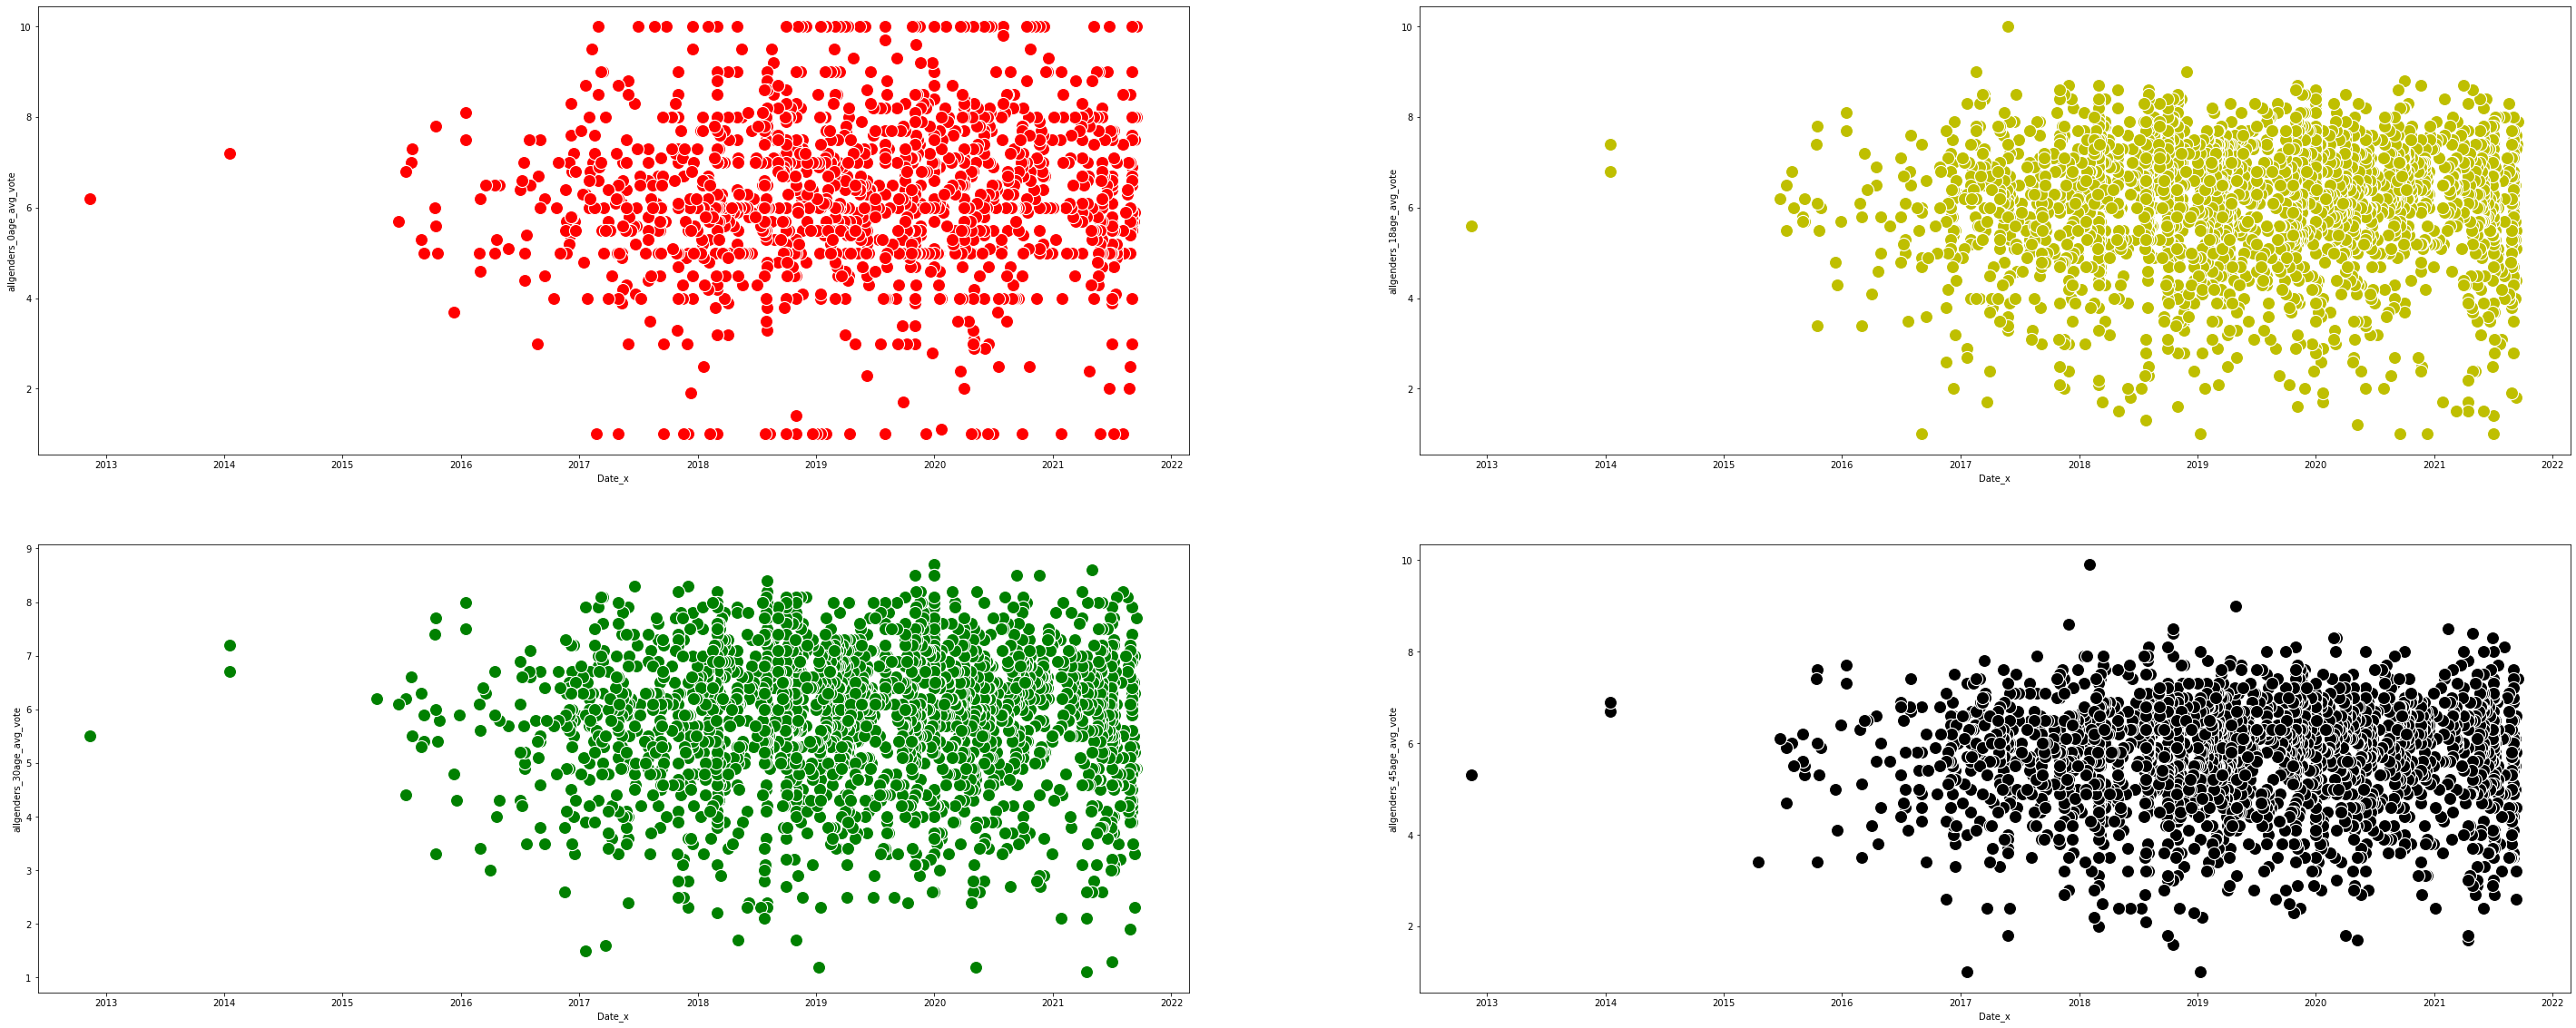

In [37]:
plt.figure(figsize = (50, 20))
plt.subplot(2,2,1)
sns.scatterplot(x='Date_x', y='allgenders_0age_avg_vote', data=df_titles_rating_stockprice_SP500, color='r', s=200)
plt.subplot(2,2,2)
sns.scatterplot(x='Date_x', y='allgenders_18age_avg_vote', data=df_titles_rating_stockprice_SP500, color='y', s=200)
plt.subplot(2,2,3)
sns.scatterplot(x='Date_x', y='allgenders_30age_avg_vote', data=df_titles_rating_stockprice_SP500, color='g', s=200)
plt.subplot(2,2,4)
sns.scatterplot(x='Date_x', y='allgenders_45age_avg_vote', data=df_titles_rating_stockprice_SP500, color='k', s=200)

빨강 --> 18세 미만 청소년층은 고르게 분포되며 1점, 10점 평점을 많이 준다 (취향이 뚜렷하다, 대체로 긍정적이지만 극단적임)

노랑 --> 18-30세 청년층은 평점이 청소년에 비해서 약간 좁아지되 극단적 긍부정은 없고 대체로 5-8점에 분포하지만 10대에 비해 비판(2~4점)도 어느 정도 한다 (대체로 긍정적이고 비판도 함) 

초록 --> 30-45세 중년층은 평점이 대체로 4~8점 중간 쪽에 좁아져 분포되어 있다 (다수를 따르는 취향, 대체로 무난)

검정 --> 45세 이상 장년층은 중년층과 비슷하지만 영화를 많이 보며 뻔하다고 느껴서인지 아래 쪽으로 다소 쏠려 있다 (냉철하다, 대체로 부정적)

Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-package

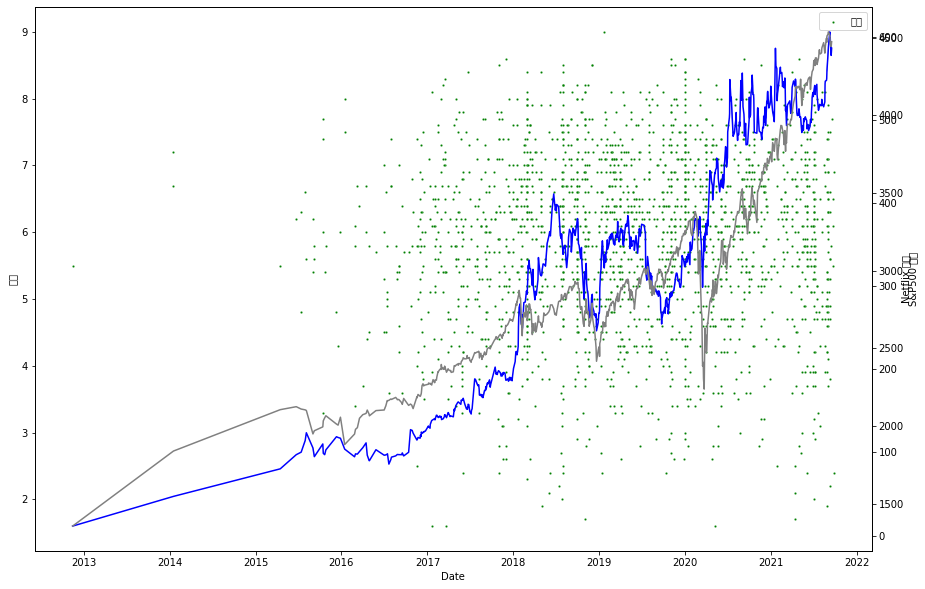

In [61]:
fig, axe1 = plt.subplots(figsize = (15, 10)) # figsize 안에 넣어야 적용됨
axe2 = axe1.twinx() # scatterplot axe3을 적어줘야 함
axe3 = axe1.twinx()

c1 = sns.scatterplot(ax = axe1, data = df_titles_rating_stockprice, x = 'Date', y = 'weighted_average_vote', color = 'g', s=5)
c2 = sns.lineplot(ax = axe2, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'Adj Close_x', color = 'b')
c3 = sns.lineplot(ax = axe3, data = df_titles_rating_stockprice_SP500, x = 'Date_y', y = 'Adj Close_y', color = 'gray')


axe1.legend(['평점', 'Netflix 주가','S&P500 지수'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe1.set_ylabel('평점')
axe2.set_ylabel('Netflix 주가')
axe3.set_ylabel('S&P500 지수')



--> 전체 평점 : 위, 아래 적고 중간 값이 많다 

1. 4~8점 사이 중간대 점수를 주는 사람
3. 나머지 사람
순으로 많다

19년 중반 교차 부분에서는 부정적 평가가 다소 늘어난다

상관관계 찾기 어렵다... 주가와 가장 상관관계 있는 성별/연령대별 평점은?


# 연령대별 평점 특징


Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52789 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-package

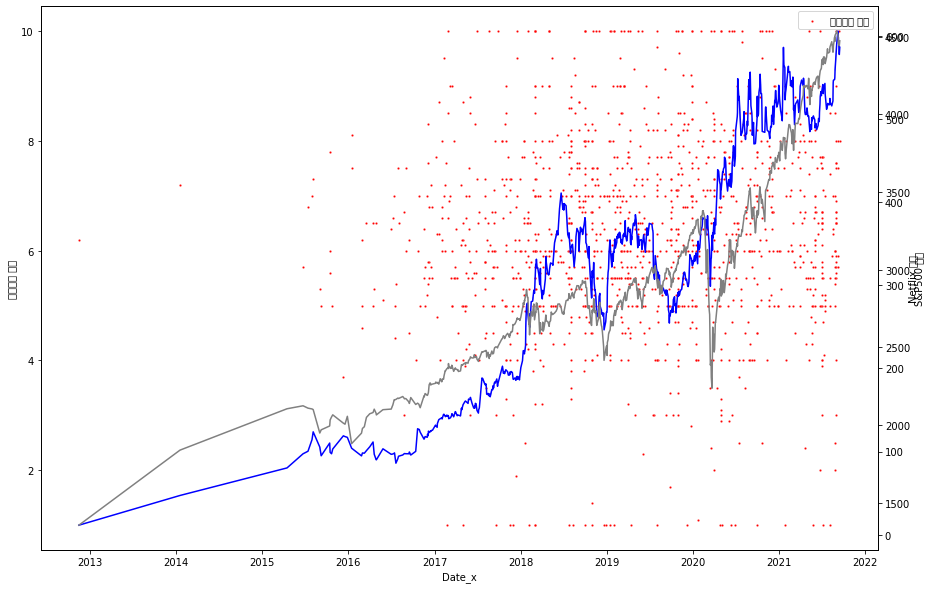

In [62]:
fig, axe1 = plt.subplots(figsize = (15, 10)) # figsize 안에 넣어야 적용됨
axe2 = axe1.twinx() # scatterplot axe3을 적어줘야 함
axe3 = axe1.twinx()

c1 = sns.scatterplot(ax = axe1, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'allgenders_0age_avg_vote', color = 'r', s=5)
c2 = sns.lineplot(ax = axe2, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'Adj Close_x', color = 'b')
c3 = sns.lineplot(ax = axe3, data = df_titles_rating_stockprice_SP500, x = 'Date_y', y = 'Adj Close_y', color = 'gray')


axe1.legend(['청소년층 평점', 'Netflix 주가','S&P500 지수'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe1.set_ylabel('청소년층 평점')
axe2.set_ylabel('Netflix 주가')
axe3.set_ylabel('S&P500 지수')


Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52789 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-package

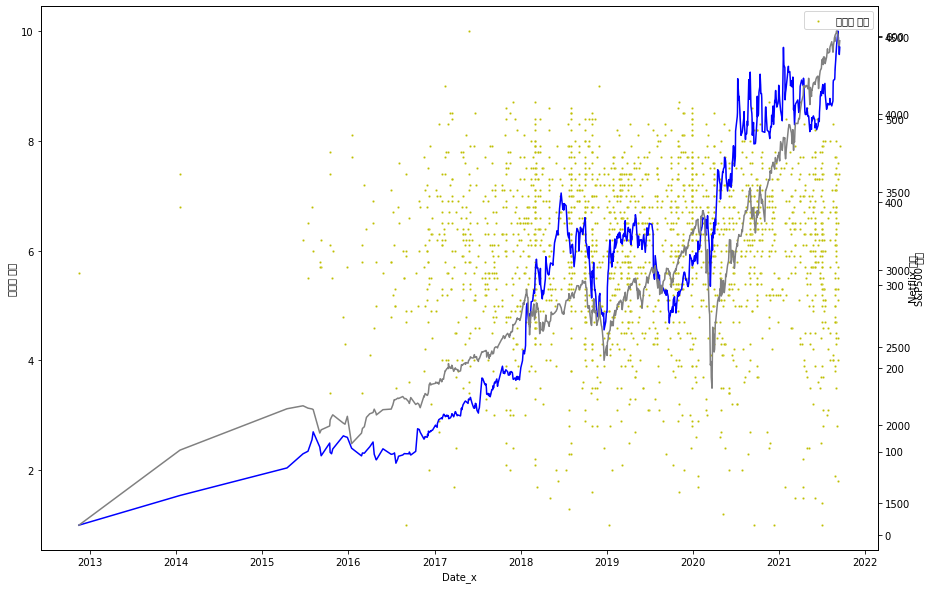

In [63]:
fig, axe1 = plt.subplots(figsize = (15, 10)) # figsize 안에 넣어야 적용됨
axe2 = axe1.twinx() # scatterplot axe3을 적어줘야 함
axe3 = axe1.twinx()

c1 = sns.scatterplot(ax = axe1, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'allgenders_18age_avg_vote', color = 'y', s=5)
c2 = sns.lineplot(ax = axe2, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'Adj Close_x', color = 'b')
c3 = sns.lineplot(ax = axe3, data = df_titles_rating_stockprice_SP500, x = 'Date_y', y = 'Adj Close_y', color = 'gray')


axe1.legend(['청년층 평점','Netflix 주가','S&P500 지수'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe1.set_ylabel('청년층 평점')
axe2.set_ylabel('Netflix 주가')
axe3.set_ylabel('S&P500 지수')


Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52789 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-package

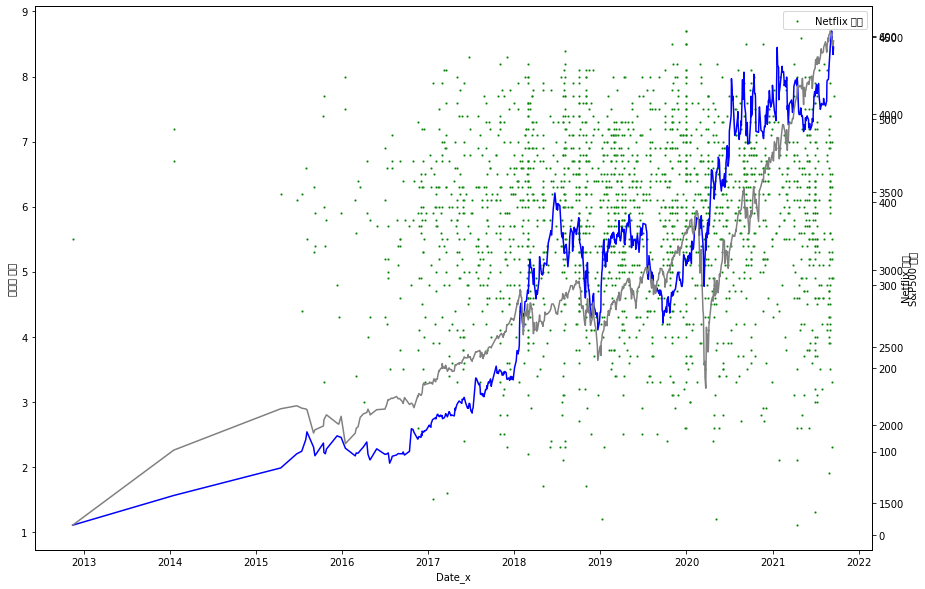

In [39]:
--> 대체로 부정적(2~4점) 평가가 많은 시기에 주가 조정/횡보기, 부정적 평가가 적은 시기가 주가 상승기와 겹친다


# 30-45세 중년층 평점 - 주가ㅇㅇ

Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52789 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-package

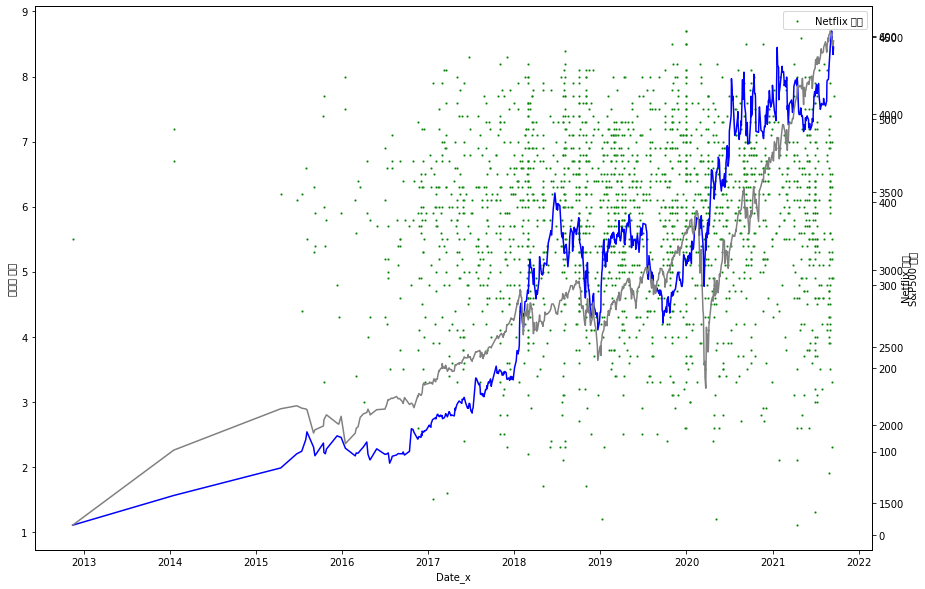

In [64]:
fig, axe1 = plt.subplots(figsize = (15, 10)) # figsize 안에 넣어야 적용됨
axe2 = axe1.twinx() # scatterplot axe3을 적어줘야 함
axe3 = axe1.twinx()

c1 = sns.scatterplot(ax = axe1, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'allgenders_30age_avg_vote', color = 'g', s=5)
c2 = sns.lineplot(ax = axe2, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'Adj Close_x', color = 'b')
c3 = sns.lineplot(ax = axe3, data = df_titles_rating_stockprice_SP500, x = 'Date_y', y = 'Adj Close_y', color = 'gray')


axe1.legend(['Netflix 주가','S&P500 지수', '중년층 평점'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe1.set_ylabel('중년층 평점')
axe2.set_ylabel('Netflix 주가')
axe3.set_ylabel('S&P500 지수')

--> 관련성 찾기 어려워짐 (트렌드보다는 소신껏 평점을 매긴다)


# 45세 이상 장년층 평점 - 주가 

Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52789 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-package

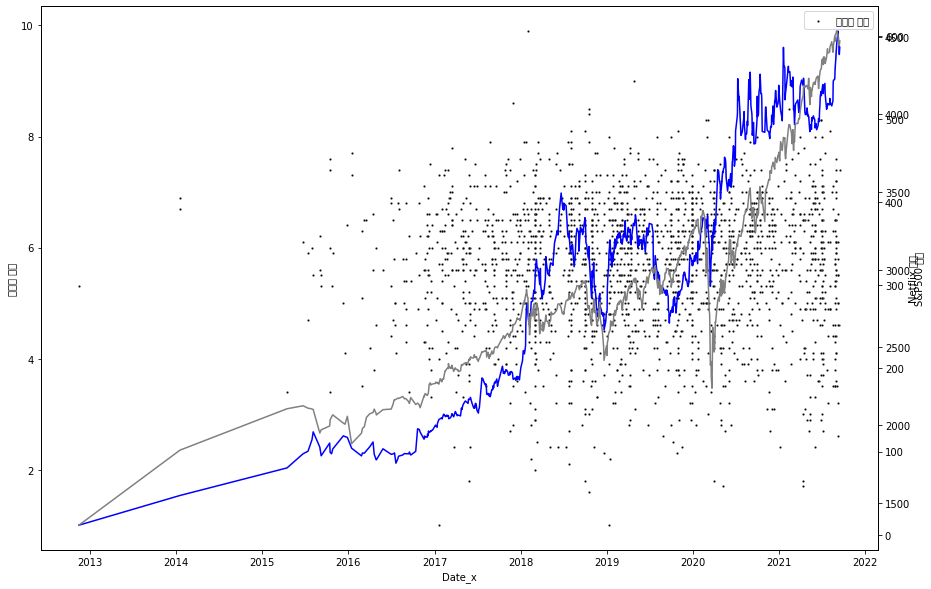

In [65]:
fig, axe1 = plt.subplots(figsize = (15, 10)) # figsize 안에 넣어야 적용됨
axe2 = axe1.twinx() # scatterplot axe3을 적어줘야 함
axe3 = axe1.twinx()

c1 = sns.scatterplot(ax = axe1, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'allgenders_45age_avg_vote', color = 'k', s=5)
c2 = sns.lineplot(ax = axe2, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'Adj Close_x', color = 'b')
c3 = sns.lineplot(ax = axe3, data = df_titles_rating_stockprice_SP500, x = 'Date_y', y = 'Adj Close_y', color = 'gray')


axe1.legend([ '장년층 평점', 'Netflix 주가','S&P500 지수'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe1.set_ylabel('장년층 평점')
axe2.set_ylabel('Netflix 주가')
axe3.set_ylabel('S&P500 지수')

--> 관련성 거의 없어짐 (넷플릭스가 잘 나갈 때도 못 나갈 때도 냉철하다, 평점 분포가 시기에 따라 별 차이가 없다, 어른들은 다 비슷하다)

--> 

넷플릭스는 대체로 컨텐츠 수가 많고 복고 컨텐츠까지 풍부하게 추가한다

디즈니플러스는 처음에 많은 수의 고품질 기존 컨텐츠를 등록했지만 신규 컨텐츠는 적다

복고 컨텐츠 전략을 확인하기에는 디즈니+가 2019년부터여서 데이터가 너무 적다

In [12]:
# netflix 주가&거래량 데이터 불러오기


--> 최신 컨텐츠 항상 확보하려는 경향, 점점 복고 컨텐츠 추가하는 경향

Date      High       Low      Open     Close       Volume  Adj Close
0  2002-05-23  1.242857  1.145714  1.156429  1.196429  104790000.0   1.196429
1  2002-05-24  1.225000  1.197143  1.214286  1.210000   11104800.0   1.210000
2  2002-05-28  1.232143  1.157143  1.213571  1.157143    6609400.0   1.157143
3  2002-05-29  1.164286  1.085714  1.164286  1.103571    6757800.0   1.103571
4  2002-05-30  1.107857  1.071429  1.107857  1.071429   10154200.0   1.071429

--> 처음에는 최신물만 취급하다가 점점 복고 컨텐츠로 확장


그래프 한번에 여러개 그리기 (여러 축)
https://pbj0812.tistory.com/45

# 개봉연도 - 연령대별 평점 

<AxesSubplot:xlabel='release_year', ylabel='allgenders_45age_avg_vote'>

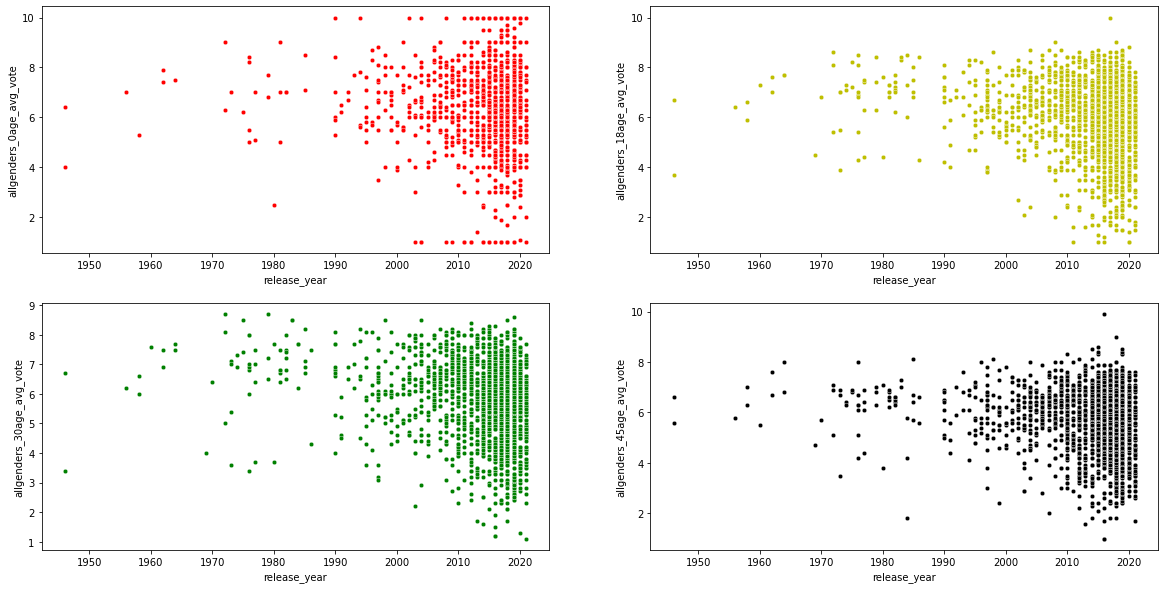

In [147]:
plt.figure(figsize = (20, 10))
plt.subplot(2,2,1)
sns.scatterplot(x='release_year', y='allgenders_0age_avg_vote', data=df_titles_rating_stockprice_SP500, color='r', s=20)
plt.subplot(2,2,2)
sns.scatterplot(x='release_year', y='allgenders_18age_avg_vote', data=df_titles_rating_stockprice_SP500, color='y', s=20)
plt.subplot(2,2,3)
sns.scatterplot(x='release_year', y='allgenders_30age_avg_vote', data=df_titles_rating_stockprice_SP500, color='g', s=20)
plt.subplot(2,2,4)
sns.scatterplot(x='release_year', y='allgenders_45age_avg_vote', data=df_titles_rating_stockprice_SP500, color='k', s=20)




# 추가된 컨텐츠 발매연도 - 주가 관계

Text(0, 0.5, 'Stock Price')

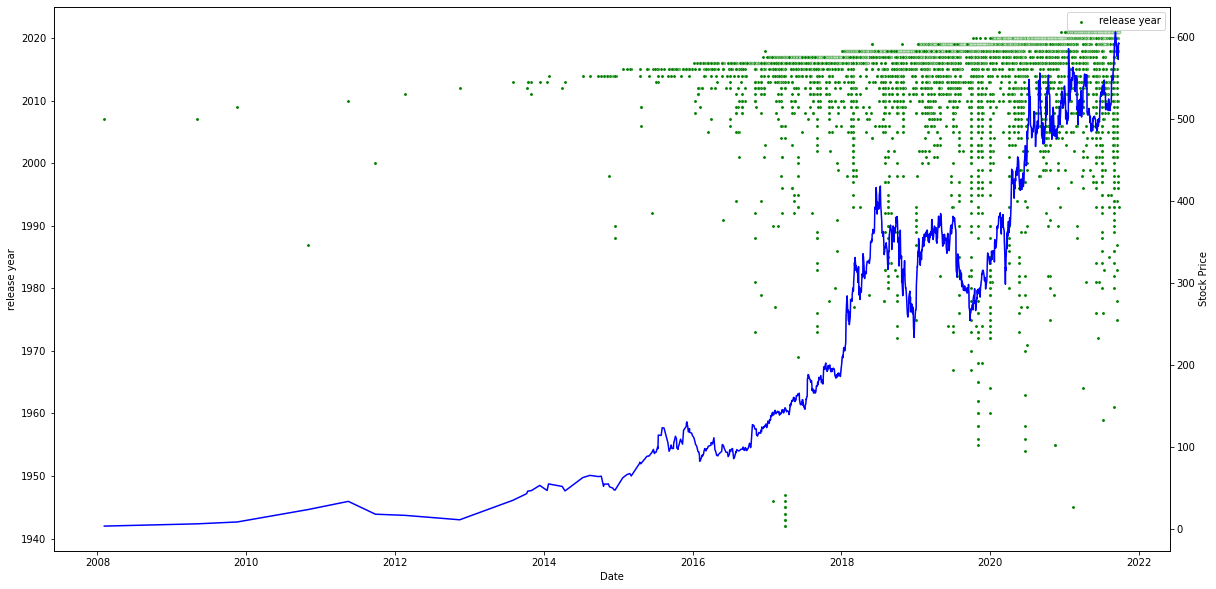

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [58]:
fig, axe1 = plt.subplots(figsize = (20, 10)) # figsize 안에 넣어야 적용됨
axe2 = axe1.twinx()

c1 = sns.scatterplot(ax = axe1, data = df_titles_stockprice, x = 'Date', y = 'release_year', color = 'g', s=10)
c2 = sns.lineplot(ax = axe2, data = df_titles_stockprice, x = 'Date', y = 'Adj Close', color = 'b')

axe1.legend(['release year','Stock Price'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe1.set_ylabel('release year')
axe2.set_ylabel('Stock Price')

--> 대체로 Movie에 따라감, 초반 빼고는 별 차이가 없음



--> 안 찍힘? 발매연도 대신 평점, 주제(description sentiment 분석)와의 관계도 봐야함 + 거래량 대신 실적과도 + 디즈니 등 다른 곳 영화들도 (복고 등) + 평 좋은 영화 감독/배우 몇명 집어서 주가.거래량.실적과 비교(흥행보증수표)

S&P 500 등 평균그래프도

실제 뉴스, 리포트와 비교(전략, 성공요인 맞는지) + 그래프 미화

넷플릭스 : 양은 많은데 질이 떨어진다
디즈니 : 질은 좋은데 양이 없다

In [22]:
# 평점 데이터 합친 netflix_titles + netflix_imdb 불러오기

Unnamed: 0 show_id     type              title     director_x  \
0           0      s6  TV Show      Midnight Mass  Mike Flanagan   
1           1      s8    Movie            Sankofa   Haile Gerima   
2           2     s16  TV Show  Dear White People            NaN   
3           3     s20  TV Show             Jaguar            NaN   
4           4     s25    Movie              Jeans     S. Shankar   

                                                cast  \
0  Kate Siegel, Zach Gilford, Hamish Linklater, H...   
1  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
2  Logan Browning, Brandon P. Bell, DeRon Horton,...   
3  Blanca Suárez, Iván Marcos, Óscar Casas, Adriá...   
4  Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...   

                                           country_x          date_added  \
0                                                NaN  September 24, 2021   
1  United States, Ghana, Burkina Faso, United Kin...  September 24, 2021   
2                                      United States  September 22, 2021   
3                                                NaN  September 22, 2021   
4                                              India  September 21, 2021   

   release_year rating  ... females_30age_avg_vote females_30age_votes  \
0          2021  TV-MA  ...                    3.0                25.0   
1          1993  TV-MA  ...                    7.7                52.0   
2          2021  TV-MA  ...                    6.6              2437.0   
3          2021  TV-MA  ...                    8.7                 3.0   
4          1998  TV-14  ...                    6.0               224.0   

  females_45age_avg_vote females_45age_votes top1000_voters_rating  \
0                    2.7                13.0                   3.3   
1                    8.3                42.0                   3.8   
2                    6.3               505.0                   5.0   
3                    NaN                 NaN                   5.0   
4                    5.5                96.0                   5.5   

  top1000_voters_votes us_voters_rating us_voters_votes  non_us_voters_rating  \
0                 29.0              2.6           190.0                   2.1   
1                 20.0              7.3           259.0                   5.8   
2                214.0              6.2          6506.0                   6.0   
3                  4.0              6.4            16.0                   5.5   
4                 23.0              5.6           383.0                   6.3   

  non_us_voters_votes  
0               125.0  
1               105.0  
2              8096.0  
3                78.0  
4              1584.0  

[5 rows x 82 columns]

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/past/builti

Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/

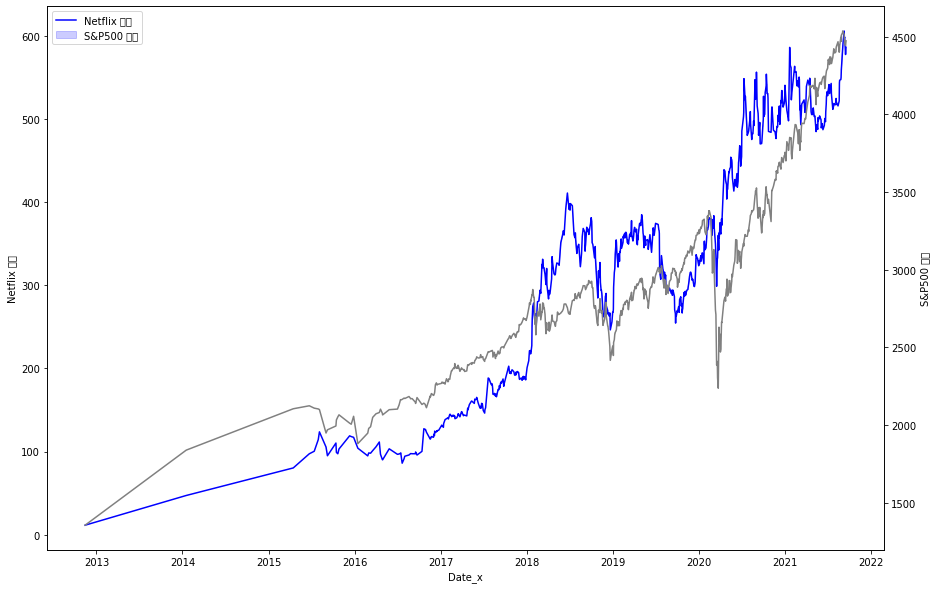

In [59]:
fig, axe2 = plt.subplots(figsize = (15, 10)) # figsize 안에 넣어야 적용됨, 숫자 바꿔주기
axe3 = axe2.twinx() # 숫자 바꿔주기

c2 = sns.lineplot(ax = axe2, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'Adj Close_x', color = 'b')
c3 = sns.lineplot(ax = axe3, data = df_titles_rating_stockprice_SP500, x = 'Date_y', y = 'Adj Close_y', color = 'gray')

axe2.legend(['Netflix 주가','S&P500 지수'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe2.set_ylabel('Netflix 주가')
axe3.set_ylabel('S&P500 지수')


--> 2018초, 2019초, 2020초에 Netflix가 S&P500 대비 초과상승

19년 말에 S&P500은 오르는데 netflix 주가는 떨어지는 교차 부분 존재 : 디즈니+ 등 경쟁자 등장 


# 개봉연도 - 주가(S&P500포함)

Text(0, 0.5, 'S&P500 지수')

/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48393 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/taekkim/opt/anaconda3/lib/python3.8/site-package

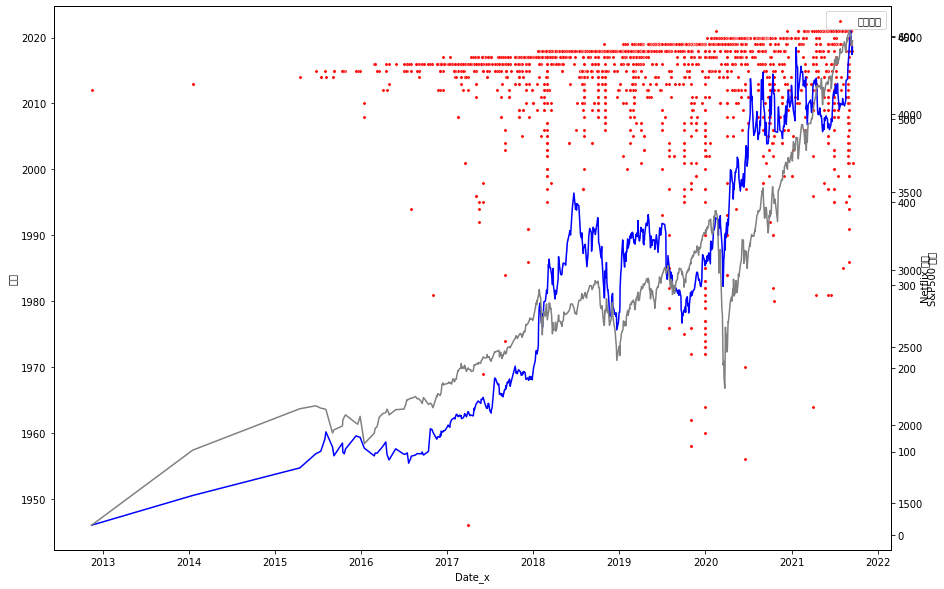

In [60]:
fig, axe1 = plt.subplots(figsize = (15, 10)) # figsize 안에 넣어야 적용됨
axe2 = axe1.twinx() # scatterplot axe3을 적어줘야 함
axe3 = axe1.twinx()

c1 = sns.scatterplot(ax = axe1, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'release_year', color = 'r', s=10)
c2 = sns.lineplot(ax = axe2, data = df_titles_rating_stockprice_SP500, x = 'Date_x', y = 'Adj Close_x', color = 'b')
c3 = sns.lineplot(ax = axe3, data = df_titles_rating_stockprice_SP500, x = 'Date_y', y = 'Adj Close_y', color = 'gray')


axe1.legend(['개봉연도', 'Netflix 주가','S&P500 지수'])

#plt.legend(bbox_to_anchor=(1.03, 1), loc=2) #legend 그래프 밖에 추가하기인데 안 먹힘

axe1.set_ylabel('평점')
axe2.set_ylabel('Netflix 주가')
axe3.set_ylabel('S&P500 지수')

In [24]:
# 평점 대결 (복고컨텐츠vs최신컨텐츠)

<AxesSubplot:xlabel='release_year', ylabel='weighted_average_vote'>

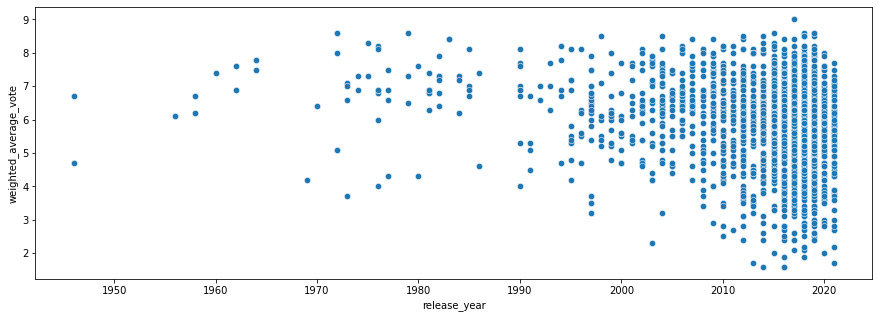

In [66]:
prac = df_titles_rating_stockprice_SP500.copy()
plt.figure(figsize = (15, 5)) # figsize 안에 넣어야 적용됨
sns.scatterplot(data = prac, x = 'release_year', y = 'weighted_average_vote', s=40)

--> 복고 컨텐츠보다 최신 컨텐츠일수록 악평이 많이 달리는 것처럼 보인다


In [25]:
# 5.0 미만 낮은 평점이 달리는 컨텐츠 : 복고보다는 최신

In [26]:
prac = df_titles_rating_stockprice_SP500.copy()
prac.sort_values(by='weighted_average_vote', ascending=True, inplace=True)
prac.reset_index(drop=True, inplace=True) #drop은 새로운 index컬럼 안 생기게, inplace는 원본 수정o
prac['weighted_average_vote'] # 값 없는 부분은 NaN표시 유의

0       1.6
1       1.6
2       1.6
3       1.7
4       1.7
       ... 
2168    8.6
2169    8.6
2170    8.6
2171    8.6
2172    9.0
Name: weighted_average_vote, Length: 2173, dtype: float64

In [27]:
prac[prac['weighted_average_vote'] < 5.0]

Unnamed: 0 show_id     type                title  \
0           695   s2556    Movie              Aerials   
1          1790   s5630    Movie                 Pink   
2          2926   s8716    Movie  Welcome to New York   
3          1332   s4443    Movie           Himmatwala   
4           274   s1051    Movie          Ride or Die   
..          ...     ...      ...                  ...   
457          65    s223  TV Show            Clickbait   
458        2736   s8182    Movie   The Adventure Club   
459          60    s211    Movie           Ragini MMS   
460        1336   s4449    Movie          Katti Batti   
461        1659   s5215    Movie            Baadshaho   

                  director_x  \
0                 S.A. Zaidi   
1    Aniruddha Roy Chowdhury   
2               Abel Ferrara   
3                 Sajid Khan   
4             Ryuichi Hiroki   
..                       ...   
457            Brad Anderson   
458           Geoff Anderson   
459          Pawan Kripalani   
460            Nikhil Advani   
461            Milan Luthria   

                                                  cast              country_x  \
0    Saga Alyasery, Ana Druzhynina, Mansour Al Fele...   United Arab Emirates   
1    Tapsee Pannu, Kirti Kulhari, Andrea Tariang, A...                  India   
2    Gérard Depardieu, Jacqueline Bisset, Marie Mou...  United States, France   
3    Ajay Devgn, Tamannaah Bhatia, Paresh Rawal, Za...                  India   
4    Kiko Mizuhara, Honami Sato, Yoko Maki, Anne Su...                  Japan   
..                                                 ...                    ...   
457  Zoe Kazan, Betty Gabriel, Adrian Grenier, Phoe...                    NaN   
458  Sam Ashe Arnold, Jakob Davies, Dalila Bela, Ro...                 Canada   
459  Kainaz Motivala, Rajkummar Rao, Rajat Kaul, Ja...                  India   
460  Imran Khan, Kangana Ranaut, Abhishek Saha, Mit...                  India   
461  Ajay Devgn, Emraan Hashmi, Vidyut Jamwal, Ilea...                  India   

    date_added  release_year rating  ... Adj Close_x     Date_y   Open_y  \
0   2020-05-07          2016  TV-14  ...  436.529999 2020-05-07  2878.26   
1   2017-01-20          2016  TV-14  ...  138.600006 2017-01-20  2269.96   
2   2017-03-23          2014      R  ...  141.839996 2017-03-23  2345.97   
3   2018-11-01          2013  TV-14  ...  317.380005 2018-11-01  2717.58   
4   2021-04-15          2021  TV-MA  ...  549.219971 2021-04-15  4139.76   
..         ...           ...    ...  ...         ...        ...      ...   
457 2021-08-25          2021  TV-MA  ...  547.580017 2021-08-25  4490.45   
458 2017-05-10          2016  TV-Y7  ...  160.279999 2017-05-10  2396.79   
459 2021-08-27          2011  TV-MA  ...  558.919983 2021-08-27  4474.10   
460 2018-11-01          2015  TV-14  ...  317.380005 2018-11-01  2717.58   
461 2017-10-16          2017  TV-14  ...  202.679993 2017-10-16  2555.57   

      High_y    Low_y  Close_y Adj Close_y    Volume_y  % Gain/Loss (Close)  \
0    2901.92  2876.48  2881.19     2881.19  5164640000               1.1374   
1    2276.96  2265.01  2271.31     2271.31  3524970000               0.3355   
2    2358.92  2342.13  2345.96     2345.96  3260600000              -0.1061   
3    2741.67  2708.85  2740.37     2740.37  4708420000               1.0448   
4    4173.49  4139.76  4170.42     4170.42  4027680000               1.0972   
..       ...      ...      ...         ...         ...                  ...   
457  4501.71  4485.66  4496.19     4496.19  2554680000               0.2215   
458  2399.74  2392.79  2399.63     2399.63  3643530000               0.1129   
459  4513.33  4474.10  4509.37     4509.37  2862360000               0.8731   
460  2741.67  2708.85  2740.37     2740.37  4708420000               1.0448   
461  2559.47  2552.64  2557.64     2557.64  2916020000               0.1748   

    % Price Variation  
0               0.009  
1               0.005  
2               0.007  
3   

In [28]:
prac = prac.iloc[:462] #자르기
prac.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='release_year', ylabel='weighted_average_vote'>

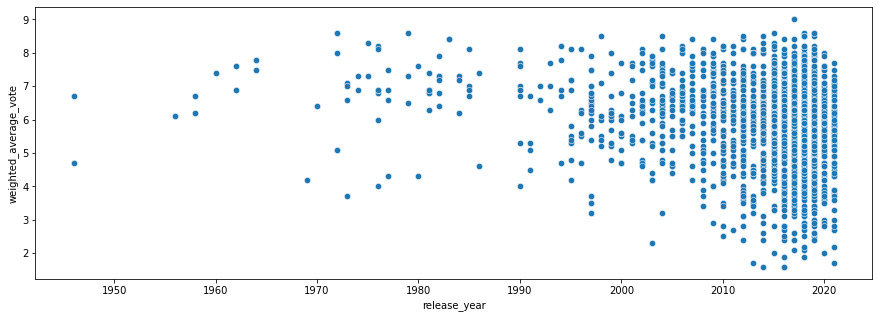

In [67]:
plt.figure(figsize = (15, 5)) # figsize 안에 넣어야 적용됨
sns.scatterplot(data = prac, x = 'release_year', y = 'weighted_average_vote', s=40)


--> 5점 미만의 악평은 복고 컨텐츠에는 희박하지만 최신 컨텐츠에서는 빈번하다.

다만 최신 컨텐츠에는 나름 호평과 악평 골고루 많으므로 실제로 복고 컨텐츠가 더 평이 좋은지 보려면 평균을 내야 한다.

In [29]:
# 복고컨텐츠와 최신컨텐츠, 옛날 것일 수록 평이 좋을까?

In [32]:
prac = df_titles_rating_stockprice_SP500.copy()
prac.sort_values(by='release_year', ascending=True, inplace=True)
prac.reset_index(drop=True, inplace=True) #drop은 새로운 index컬럼 안 생기게, inplace는 원본 수정o
prac['release_year'] # 값 없는 부분은 NaN표시 유의

0       1946
1       1946
2       1956
3       1958
4       1958
        ... 
2168    2021
2169    2021
2170    2021
2171    2021
2172    2021
Name: release_year, Length: 2173, dtype: int64

개봉연도별로 정렬 후 범위 보고 잘라서 연도 구간별 평균

prac['weighted_average_vote'].mean() 함수 이용

--> 엑셀 파일 만들어서 불러오기

In [69]:
csv_path = PATH+"old_new_vote.csv"
data6 = pd.read_csv(csv_path)
data6_copy=data6.copy()
df6 = pd.DataFrame(data6)
df6

From_1946  old_mean  By_2021  new_mean
0        1985      6.85     2000      5.86
1        1989      6.82     2001      5.86
2        1990      6.80     2002      5.82
3        1991      6.73     2003      5.78
4        1992      6.73     2004      5.77
5        1993      6.74     2005      5.73
6        1994      6.75     2006      5.72
7        1995      6.67     2007      5.70
8        1996      6.64     2008      5.62
9        1997      6.56     2009      5.40
10       1998      6.54     2010      5.80
11       1999      6.50     2011      5.75
12       2000      6.45     2012      5.69
13       2001      6.45     2013      5.77
14       2002      6.44     2014      5.77
15       2003      6.42     2015      5.76
16       2004      6.41     2016      5.73
17       2005      6.39     2017      5.73
18       2006      6.40     2018      5.68
19       2007      6.41     2019      5.62
20       2008      6.39     2020      5.56
21       2009      6.40     2021      5.34

<AxesSubplot:xlabel='By_2021', ylabel='new_mean'>

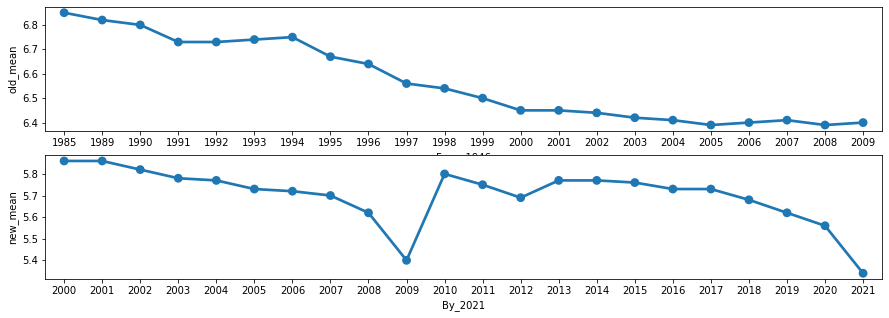

In [70]:
plt.figure(figsize = (15, 5)) # figsize 안에 넣어야 적용됨

plt.subplot(2,1,1)
sns.pointplot(data = df6, x = 'From_1946', y = 'old_mean')

plt.subplot(2,1,2)
sns.pointplot(data = df6, x = 'By_2021', y = 'new_mean')

In [ ]:
복고 컨텐츠는 (1946년부터)2009년까지의 평점 평균 vs. (1946년부터)1985년까지의 평점 평균을 볼 때 옛날 구간일수록 평점이 높아짐을 확인할 수 있다.

최신 컨텐츠는 2000년부터(2021년까지의) 평점 평균 vs. 2009년부터(2021년까지의) 평점 평균을 볼 때 최신 구간일수록 평점이 낮아짐을 확인할 수 있다.

2010년에 평점 평균의 점프가 있었지만 여전히 그 후로 2010년부터(2021년까지의) 평점 평균 vs. 2021년부터(2021년까지의) 평점 평균을 볼 때 최신 구간일수록 평점이 낮아짐을 확인할 수 있다.

즉, 복고 컨텐츠일수록 호평을, 최신 컨텐츠일수록 악평을 받는 경향을 확인할 수 있다.

--> 관련성 거의 없어짐 (넷플릭스가 잘 나갈 때도 못 나갈 때도 냉철하다, 평점 분포가 시기에 따라 별 차이가 없다, 어른들은 다 비슷하다)

In [42]:
# 디즈니 플러스 vs 넷플릭스 - 복고 컨텐츠 전략 비교

show_id     type                           title  \
0      s1    Movie                   A Spark Story   
1      s2    Movie                  Spooky Buddies   
2      s3    Movie          The Fault in Our Stars   
3      s4  TV Show                 Dog: Impossible   
4      s5  TV Show  Spidey And His Amazing Friends   

                     director  \
0  Jason Sterman, Leanne Dare   
1                Robert Vince   
2                  Josh Boone   
3                         NaN   
4                         NaN   

                                                cast                country  \
0                      Apthon Corbin, Louis Gonzales                    NaN   
1  Tucker Albrizzi, Diedrich Bader, Ameko Eks Mas...  United States, Canada   
2  Shailene Woodley, Ansel Elgort, Laura Dern, Sa...          United States   
3                                       Matt Beisner          United States   
4  Benjamin Valic, Lily Sanfelippo, Jakari Fraser...          United States   

           date_added  release_year rating   duration  \
0  September 24, 2021          2021  TV-PG     88 min   
1  September 24, 2021          2011      G     93 min   
2  September 24, 2021          2014  PG-13    127 min   
3  September 22, 2021          2019  TV-PG  2 Seasons   
4  September 22, 2021          2021   TV-Y   1 Season   

                              listed_in  \
0                           Documentary   
1                 Comedy, Fantasy, Kids   
2         Coming of Age, Drama, Romance   
3  Animals & Nature, Docuseries, Family   
4     Action-Adventure, Animation, Kids   

                                         description  
0  Two Pixar filmmakers strive to bring their uni...  
1  The puppies go on a spooky adventure through a...  
2  Hazel and Gus share a love that sweeps them on...  
3  Matt Beisner uses unique approaches to modifyi...  
4  Spidey teams up with pals to become The Spidey...

In [18]:
csv_path = PATH + "disney_plus_titles.csv"
data5 = pd.read_csv(csv_path)
data5_copy=data5.copy()
df5 = pd.DataFrame(data5)
df5.head()

show_id     type                           title  \
0      s1    Movie                   A Spark Story   
1      s2    Movie                  Spooky Buddies   
2      s3    Movie          The Fault in Our Stars   
3      s4  TV Show                 Dog: Impossible   
4      s5  TV Show  Spidey And His Amazing Friends   

                     director  \
0  Jason Sterman, Leanne Dare   
1                Robert Vince   
2                  Josh Boone   
3                         NaN   
4                         NaN   

                                                cast                country  \
0                      Apthon Corbin, Louis Gonzales                    NaN   
1  Tucker Albrizzi, Diedrich Bader, Ameko Eks Mas...  United States, Canada   
2  Shailene Woodley, Ansel Elgort, Laura Dern, Sa...          United States   
3                                       Matt Beisner          United States   
4  Benjamin Valic, Lily Sanfelippo, Jakari Fraser...          United States   

           date_added  release_year rating   duration  \
0  September 24, 2021          2021  TV-PG     88 min   
1  September 24, 2021          2011      G     93 min   
2  September 24, 2021          2014  PG-13    127 min   
3  September 22, 2021          2019  TV-PG  2 Seasons   
4  September 22, 2021          2021   TV-Y   1 Season   

                              listed_in  \
0                           Documentary   
1                 Comedy, Fantasy, Kids   
2         Coming of Age, Drama, Romance   
3  Animals & Nature, Docuseries, Family   
4     Action-Adventure, Animation, Kids   

                                         description  
0  Two Pixar filmmakers strive to bring their uni...  
1  The puppies go on a spooky adventure through a...  
2  Hazel and Gus share a love that sweeps them on...  
3  Matt Beisner uses unique approaches to modifyi...  
4  Spidey teams up with pals to become The Spidey...

In [19]:
df5['date_added'] = pd.to_datetime(df5['date_added'])
df5.head()

show_id     type                           title  \
0      s1    Movie                   A Spark Story   
1      s2    Movie                  Spooky Buddies   
2      s3    Movie          The Fault in Our Stars   
3      s4  TV Show                 Dog: Impossible   
4      s5  TV Show  Spidey And His Amazing Friends   

                     director  \
0  Jason Sterman, Leanne Dare   
1                Robert Vince   
2                  Josh Boone   
3                         NaN   
4                         NaN   

                                                cast                country  \
0                      Apthon Corbin, Louis Gonzales                    NaN   
1  Tucker Albrizzi, Diedrich Bader, Ameko Eks Mas...  United States, Canada   
2  Shailene Woodley, Ansel Elgort, Laura Dern, Sa...          United States   
3                                       Matt Beisner          United States   
4  Benjamin Valic, Lily Sanfelippo, Jakari Fraser...          United States   

  date_added  release_year rating   duration  \
0 2021-09-24          2021  TV-PG     88 min   
1 2021-09-24          2011      G     93 min   
2 2021-09-24          2014  PG-13    127 min   
3 2021-09-22          2019  TV-PG  2 Seasons   
4 2021-09-22          2021   TV-Y   1 Season   

                              listed_in  \
0                           Documentary   
1                 Comedy, Fantasy, Kids   
2         Coming of Age, Drama, Romance   
3  Animals & Nature, Docuseries, Family   
4     Action-Adventure, Animation, Kids   

                                         description  
0  Two Pixar filmmakers strive to bring their uni...  
1  The puppies go on a spooky adventure through a...  
2  Hazel and Gus share a love that sweeps them on...  
3  Matt Beisner uses unique approaches to modifyi...  
4  Spidey teams up with pals to become The Spidey...

In [20]:
df.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

  date_added  release_year rating   duration  \
0 2021-09-25          2020  PG-13     90 min   
1 2021-09-24          2021  TV-MA  2 Seasons   
2 2021-09-24          2021  TV-MA   1 Season   
3 2021-09-24          2021  TV-MA   1 Season   
4 2021-09-24          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [21]:
prac = df.copy()
prac.sort_values(by='date_added', ascending=True, inplace=True)
prac.reset_index(drop=True, inplace=True) #drop은 새로운 index컬럼 안 생기게, inplace는 원본 수정o
prac[prac['date_added'] > '2019-10-01']

show_id     type                                    title  \
4819   s6361  TV Show                            Border Patrol   
4820   s3461    Movie  Salam - The First ****** Nobel Laureate   
4821   s6619  TV Show                              Diva Brides   
4822   s7298  TV Show              License to Drill: Louisiana   
4823   s7216  TV Show                          Kitten Rescuers   
...      ...      ...                                      ...   
8792      s7    Movie         My Little Pony: A New Generation   
8793      s8    Movie                                  Sankofa   
8794      s9  TV Show            The Great British Baking Show   
8795     s10    Movie                             The Starling   
8796      s1    Movie                     Dick Johnson Is Dead   

                           director  \
4819                            NaN   
4820                Anand Kamalakar   
4821                            NaN   
4822                            NaN   
4823                            NaN   
...                             ...   
8792  Robert Cullen, José Luis Ucha   
8793                   Haile Gerima   
8794                Andy Devonshire   
8795                 Theodore Melfi   
8796                Kirsten Johnson   

                                                   cast  \
4819                                      Timothy Balme   
4820                                                NaN   
4821                                                NaN   
4822                                                NaN   
4823                                           Jo Brand   
...                                                 ...   
8792  Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
8793  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
8794  Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...   
8795  Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...   
8796                                                NaN   

                                                country date_added  \
4819                                                NaN 2019-10-02   
4820                                      United States 2019-10-02   
4821                                                NaN 2019-10-02   
4822                                             Canada 2019-10-02   
4823                                     United Kingdom 2019-10-02   
...                                                 ...        ...   
8792                                                NaN 2021-09-24   
8793  United States, Ghana, Burkina Faso, United Kin... 2021-09-24   
8794                                     United Kingdom 2021-09-24   
8795                                      United States 2021-09-24   
8796                                      United States 2021-09-25   

      release_year rating   duration  \
4819          2016  TV-PG   1 Season   
4820          2018  TV-PG     76 min   
4821          2017  TV-MA   1 Season   
4822          2014  TV-PG   1 Season   
4823          2017  TV-14   1 Season   
...            ...    ...        ...   
8792          2021     PG     91 min   
8793          1993  TV-MA    125 min   
8794          2021  TV-14  9 Seasons   
8795          2021  PG-13    104 min   
8796          2020  PG-13     90 min   

                                              listed_in  \
4819                                         Reality TV   
4820                                      Documentaries   
4821                       British TV Shows, Reality TV   
4822                                         Reality TV   
4823  British TV Shows, International TV Shows, Real...   
...                                                 ...   
8792                           Children & Family Movies   
8793   Dramas, Independent Movies, International Movies   
8794                       British TV Shows, Reality TV   
8795                                   Comedies, Dramas   
8796                                      Documentaries   

   

In [22]:
prac = prac.iloc[4819:] #자르기
prac.reset_index(drop=True, inplace=True)
prac

show_id     type                                    title  \
0      s6361  TV Show                            Border Patrol   
1      s3461    Movie  Salam - The First ****** Nobel Laureate   
2      s6619  TV Show                              Diva Brides   
3      s7298  TV Show              License to Drill: Louisiana   
4      s7216  TV Show                          Kitten Rescuers   
...      ...      ...                                      ...   
3983   s7197  TV Show                                 Kikoriki   
3984   s7255  TV Show                      La Familia P. Luche   
3985   s7407  TV Show                                    Maron   
3986   s7848  TV Show                             Red vs. Blue   
3987   s8183  TV Show             The Adventures of Figaro Pho   

             director                                               cast  \
0                 NaN                                      Timothy Balme   
1     Anand Kamalakar                                                NaN   
2                 NaN                                                NaN   
3                 NaN                                                NaN   
4                 NaN                                           Jo Brand   
...               ...                                                ...   
3983              NaN                                      Igor Dmitriev   
3984              NaN  Eugenio Derbez, Consuelo Duval, Luis Manuel Áv...   
3985              NaN  Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...   
3986              NaN  Burnie Burns, Jason Saldaña, Gustavo Sorola, G...   
3987              NaN  Luke Jurevicius, Craig Behenna, Charlotte Haml...   

             country date_added  release_year rating    duration  \
0                NaN 2019-10-02          2016  TV-PG    1 Season   
1      United States 2019-10-02          2018  TV-PG      76 min   
2                NaN 2019-10-02          2017  TV-MA    1 Season   
3             Canada 2019-10-02          2014  TV-PG    1 Season   
4     United Kingdom 2019-10-02          2017  TV-14    1 Season   
...              ...        ...           ...    ...         ...   
3983             NaN        NaT          2010   TV-Y   2 Seasons   
3984   United States        NaT          2012  TV-14   3 Seasons   
3985   United States        NaT          2016  TV-MA   4 Seasons   
3986   United States        NaT          2015     NR  13 Seasons   
3987       Australia        NaT          2015  TV-Y7   2 Seasons   

                                              listed_in  \
0                                            Reality TV   
1                                         Documentaries   
2                          British TV Shows, Reality TV   
3                                            Reality TV   
4     British TV Shows, International TV Shows, Real...   
...                                                 ...   
3983                                           Kids' TV   
3984  International TV Shows, Spanish-Language TV Sh...   
3985                                        TV Comedies   
3986  TV Action & Adventure, TV Comedies, TV Sci-Fi ...   
3987                              Kids' TV, TV Comedies   

                                            description  
0     This reality TV series follows the men and wom...  
1     Shunned by his country due to religion, Abdus ...  
2     In this reality series, brides-to-be stop at n...  
3     A crew of oil riggers work an off-season job a...  
4     Cat-crazy host Jo Brand follows vets and anima...  
...                                                 ...  
3983  A wacky rabbit and his gang of animal pals hav...  
3984  This irreverent sitcom featues Ludovico, Feder...  
3985  Marc Maron stars as Marc Maron, who interviews...  
3986  This parody of first-person shooter games, mil...  
3987  Imagine your worst fears, then multiply them: ...  

[3988 rows x 12 columns]

<AxesSubplot:xlabel='date_added', ylabel='release_year'>

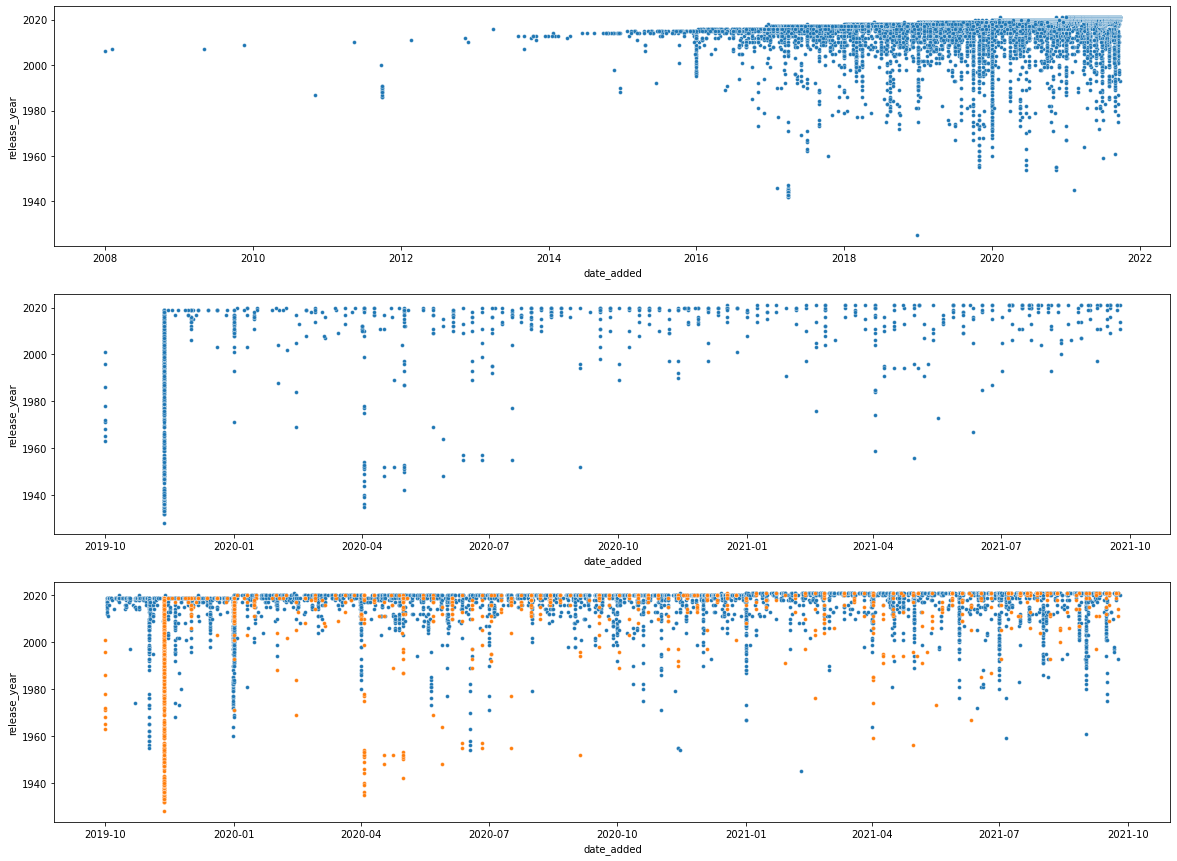

In [23]:
# 컨텐츠 추가일 - 컨텐츠 개봉연도 관계

plt.figure(figsize = (20, 15))

plt.subplot(3,1,1)
sns.scatterplot(x='date_added', y='release_year', data=df, s=15)
# 넷플릭스 2008~2021 

plt.subplot(3,1,2)
sns.scatterplot(x='date_added', y='release_year', data=df5, s=15)
# 디즈니플러스 2019.10~2021

plt.subplot(3,1,3)
sns.scatterplot(x='date_added', y='release_year', data=prac, s=15)
plt.subplot(3,1,3)
sns.scatterplot(x='date_added', y='release_year', data=df5, s=15)
# 넷플릭스+디즈니플러스 2019.10~2021

-->

넷플릭스는 대체로 컨텐츠 수가 많고 복고 컨텐츠까지 풍부하게 추가한다

디즈니플러스는 처음에 많은 수의 고품질 기존 컨텐츠를 등록했지만 신규 컨텐츠는 적다

복고 컨텐츠 전략을 확인하기에는 디즈니+가 2019년부터여서 데이터가 너무 적다